# SortaBin Waste Classifier

## **1.** Import needed libraries

In [28]:
import requests
from pathlib import Path
import zipfile
import torch
import torchvision
import os
import random
from PIL import Image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

## **2.** Device agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **3.** Get and prepare data

In [3]:
# Set data structure
data_dir = Path('data/')
image_dir = data_dir / 'waste_classification'

# Create folder
if image_dir.is_dir():
  print('Folder exists...........')
else:
  print('Creating Folder..........')
  image_dir.mkdir(parents=True, exist_ok=True)

# Get the zip file from github
with open(data_dir/'waste_classification.zip', 'wb') as f:
  request = requests.get('https://github.com/Mahesh1772/Deep_Learning/raw/main/waste_classification.zip')
  print('Downloading zip file........')
  f.write(request.content)

with zipfile.ZipFile(data_dir/'waste_classification.zip', 'r') as zip_ref:
  print('Unzipping file..........')
  zip_ref.extractall(data_dir)

Creating Folder..........
Unzipping file..........


In [4]:
# train and test directories
train_dir = image_dir / 'train'
test_dir = image_dir / 'test'

In [5]:
# Explore directory and data
for dirpath, dirnames, filenames in os.walk(image_dir):
  print(f"There are {len(filenames)} files and {len(dirnames)} directories in {dirpath}")

There are 0 files and 2 directories in data/waste_classification
There are 0 files and 7 directories in data/waste_classification/test
There are 117 files and 0 directories in data/waste_classification/test/paper
There are 107 files and 0 directories in data/waste_classification/test/plastic
There are 92 files and 0 directories in data/waste_classification/test/cardboard
There are 43 files and 0 directories in data/waste_classification/test/trash
There are 90 files and 0 directories in data/waste_classification/test/glass
There are 77 files and 0 directories in data/waste_classification/test/metal
There are 38 files and 0 directories in data/waste_classification/test/compost
There are 0 files and 7 directories in data/waste_classification/train
There are 477 files and 0 directories in data/waste_classification/train/paper
There are 375 files and 0 directories in data/waste_classification/train/plastic
There are 311 files and 0 directories in data/waste_classification/train/cardboard
Th

## **4.** Inspect Random Image (using PIL and NumPy)

Image height: 300
Image width: 400
Image shape: (400, 300)
Image label: plastic


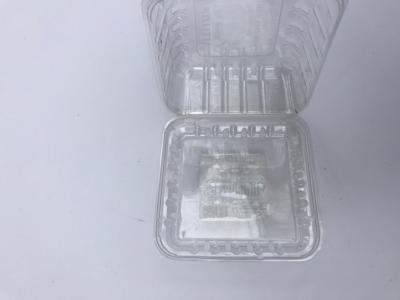

In [6]:
# Random image visualization
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get all image paths in a list
image_path_list = list(image_dir.glob('*/*/*.jpg'))

# Get a random image
random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)
label = random_image_path.parent.stem

print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image shape: {img.size}")
print(f"Image label: {label}")

img

Image height: 300
Image width: 400
Image shape: (300, 400, 3)
Image label: plastic


Text(0.5, 1.0, 'plastic')

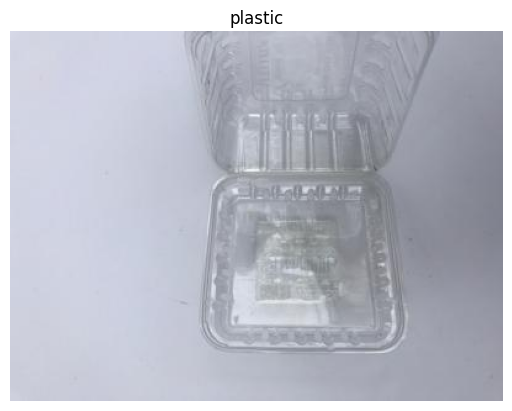

In [7]:
# Visualize same image using numpy
img_as_np = np.asarray(img)

print(f"Image height: {img_as_np.shape[0]}")
print(f"Image width: {img_as_np.shape[1]}")
print(f"Image shape: {img_as_np.shape}")
print(f"Image label: {label}")

plt.imshow(img_as_np)
plt.axis(False)
plt.title(label)

## **5.** Convert data -> Dataset -> DataLoader

In [8]:
# Define transforms for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Create datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Create data loaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
len(test_loader), len(train_loader)

(18, 69)

In [11]:
# Get some constants
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

## **6.** Image and Dataset Inspection

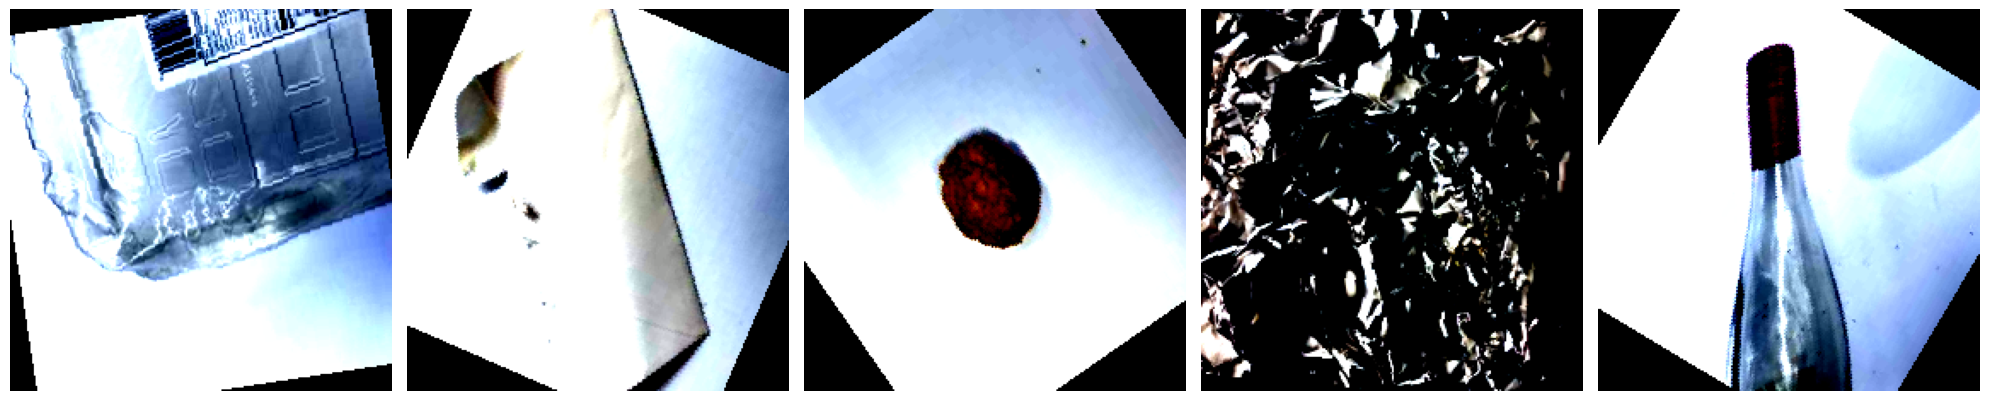

In [12]:
# Function to plot images
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show some augmented images
images = next(iter(train_loader))[0][:5]
plot_images(images)

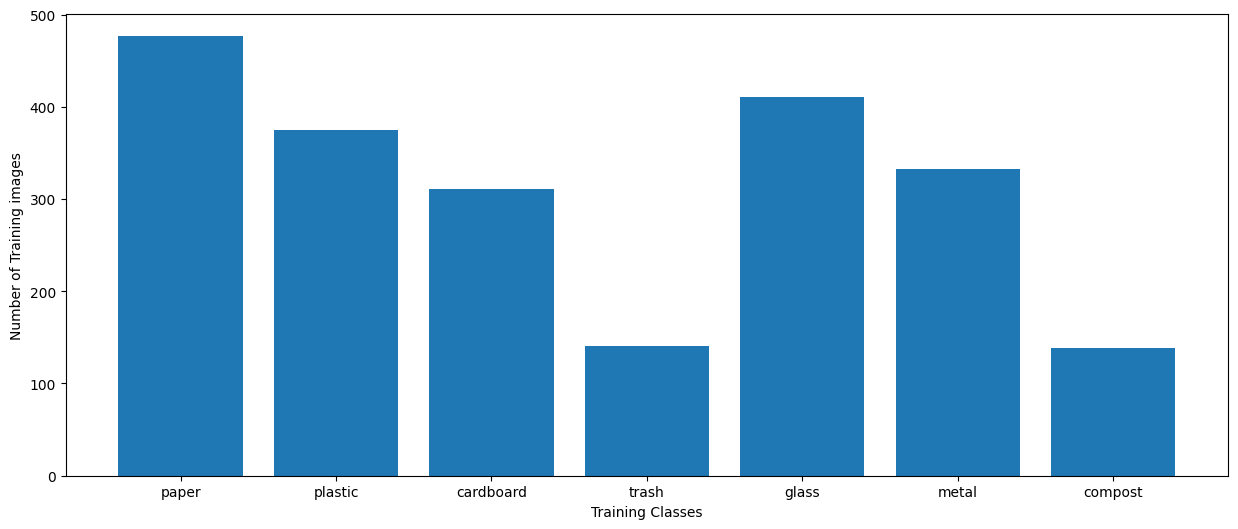

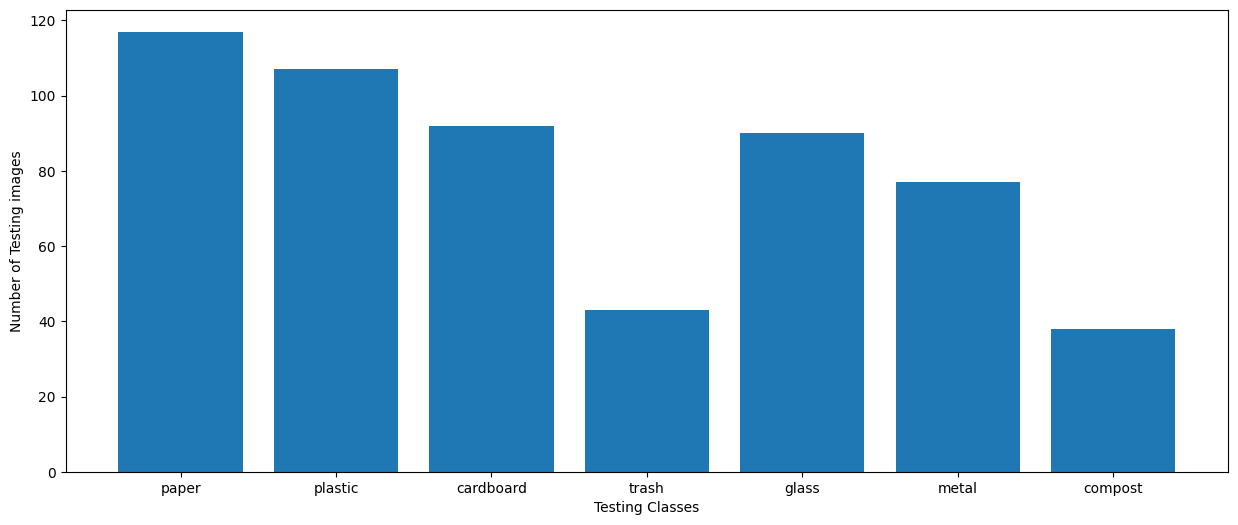

In [13]:
# Count number of images in each class
def count_images(data_dir):
    data_dict = {}
    for folder in os.listdir(data_dir):
        data_dict[folder] = len(os.listdir(os.path.join(data_dir, folder)))
    return data_dict

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Plot image counts
plt.figure(figsize=(15, 6))
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Training Classes')
plt.ylabel('Number of Training images')
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(test_counts.keys(), test_counts.values())
plt.xlabel('Testing Classes')
plt.ylabel('Number of Testing images')
plt.show()

## **7.** Pre-Trained Model initialization: Transfer Learning

In [29]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_classes = len(class_names)
model.classifier[6] = nn.Linear(4096, num_classes)

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.Adam(model.classifier[6].parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **8.** Train and Test loop intialization

In [30]:
def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [31]:
def test_step(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [32]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50):
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc, _, _ = test_step(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Get final predictions for confusion matrix
    _, _, all_preds, all_labels = test_step(model, test_loader, criterion, device)

    return history, all_preds, all_labels

## **9.** Evaluation Methods initialization

In [33]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['test_acc'], label='Test')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['test_loss'], label='Test')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
def plot_confusion_matrix(all_preds, all_labels, class_names, title):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(title + '.png')
    plt.close()

## **10.** Pre-Trained Model initialization: Fine Tuning

In [36]:
# Define image size
IMAGE_SIZE = [224, 224]

# Load pre-trained VGG16 model
base_model = models.vgg16(pretrained=True)

# Freeze early layers and unfreeze later layers for fine-tuning
for name, param in base_model.named_parameters():
    if 'features.23' in name:  # Approximately equivalent to 'block5_conv1' in TensorFlow
        break
    param.requires_grad = False
    print(f'Layer {name} frozen.')

# Modify the classifier
base_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 1000),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1000, len(class_names)),  # Assuming class_names is defined
    nn.Softmax(dim=1)
)

# Move model to device
model_Res = base_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_fine = torch.optim.Adam(model_Res.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer features.0.weight frozen.
Layer features.0.bias frozen.
Layer features.2.weight frozen.
Layer features.2.bias frozen.
Layer features.5.weight frozen.
Layer features.5.bias frozen.
Layer features.7.weight frozen.
Layer features.7.bias frozen.
Layer features.10.weight frozen.
Layer features.10.bias frozen.
Layer features.12.weight frozen.
Layer features.12.bias frozen.
Layer features.14.weight frozen.
Layer features.14.bias frozen.
Layer features.17.weight frozen.
Layer features.17.bias frozen.
Layer features.19.weight frozen.
Layer features.19.bias frozen.
Layer features.21.weight frozen.
Layer features.21.bias frozen.
Layer features.24.weight frozen.
Layer features.24.bias frozen.
Layer features.26.weight frozen.
Layer features.26.bias frozen.
Layer features.28.weight frozen.
Layer features.28.bias frozen.
Layer classifier.0.weight frozen.
Layer classifier.0.bias frozen.
Layer classifier.3.weight frozen.
Layer classifier.3.bias frozen.
Layer classifier.6.weight frozen.
Layer clas

## **11.** Train and evaluate Models

### 11.1 Transfer Learning

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.1670, Train Acc: 0.5560, Test Loss: 0.9392, Test Acc: 0.6543


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.8902, Train Acc: 0.6621, Test Loss: 0.8093, Test Acc: 0.6968


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.8388, Train Acc: 0.6996, Test Loss: 0.7318, Test Acc: 0.7234


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.8312, Train Acc: 0.6836, Test Loss: 0.7997, Test Acc: 0.6897


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.8160, Train Acc: 0.6996, Test Loss: 0.7089, Test Acc: 0.7287


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.8023, Train Acc: 0.7055, Test Loss: 0.7057, Test Acc: 0.7252


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.7903, Train Acc: 0.7133, Test Loss: 0.7074, Test Acc: 0.7376


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.7674, Train Acc: 0.7170, Test Loss: 0.6892, Test Acc: 0.7411


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.7383, Train Acc: 0.7403, Test Loss: 0.6733, Test Acc: 0.7571


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.7319, Train Acc: 0.7275, Test Loss: 0.6843, Test Acc: 0.7713


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.6748, Train Acc: 0.7558, Test Loss: 0.6483, Test Acc: 0.7677


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.7492, Train Acc: 0.7289, Test Loss: 0.6511, Test Acc: 0.7660


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.7687, Train Acc: 0.7321, Test Loss: 0.6555, Test Acc: 0.7695


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.7437, Train Acc: 0.7357, Test Loss: 0.6195, Test Acc: 0.7837


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.7274, Train Acc: 0.7403, Test Loss: 0.6222, Test Acc: 0.7890


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.7413, Train Acc: 0.7348, Test Loss: 0.6517, Test Acc: 0.7784


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.7217, Train Acc: 0.7357, Test Loss: 0.6845, Test Acc: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.7384, Train Acc: 0.7366, Test Loss: 0.6429, Test Acc: 0.7784


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.7220, Train Acc: 0.7371, Test Loss: 0.6234, Test Acc: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.6986, Train Acc: 0.7526, Test Loss: 0.5798, Test Acc: 0.7926


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.7126, Train Acc: 0.7398, Test Loss: 0.6048, Test Acc: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.6908, Train Acc: 0.7490, Test Loss: 0.6115, Test Acc: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.7031, Train Acc: 0.7540, Test Loss: 0.6253, Test Acc: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.7398, Train Acc: 0.7302, Test Loss: 0.6586, Test Acc: 0.7677


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.7633, Train Acc: 0.7215, Test Loss: 0.6181, Test Acc: 0.7730


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.7037, Train Acc: 0.7485, Test Loss: 0.7086, Test Acc: 0.7429


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.7314, Train Acc: 0.7485, Test Loss: 0.7394, Test Acc: 0.7518


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.6784, Train Acc: 0.7668, Test Loss: 0.6587, Test Acc: 0.7695


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.7257, Train Acc: 0.7462, Test Loss: 0.6402, Test Acc: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.7180, Train Acc: 0.7540, Test Loss: 0.6528, Test Acc: 0.7819


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.7303, Train Acc: 0.7444, Test Loss: 0.6381, Test Acc: 0.7748


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.7137, Train Acc: 0.7526, Test Loss: 0.6048, Test Acc: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.6692, Train Acc: 0.7641, Test Loss: 0.6324, Test Acc: 0.7748


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.7035, Train Acc: 0.7540, Test Loss: 0.6326, Test Acc: 0.7819


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.7050, Train Acc: 0.7458, Test Loss: 0.6160, Test Acc: 0.7872


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.6657, Train Acc: 0.7581, Test Loss: 0.6141, Test Acc: 0.7837


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.6805, Train Acc: 0.7508, Test Loss: 0.6162, Test Acc: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.6694, Train Acc: 0.7595, Test Loss: 0.6145, Test Acc: 0.7996


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.6769, Train Acc: 0.7549, Test Loss: 0.6247, Test Acc: 0.7926


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.7068, Train Acc: 0.7499, Test Loss: 0.6285, Test Acc: 0.7872


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.7040, Train Acc: 0.7453, Test Loss: 0.6027, Test Acc: 0.7890


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.7301, Train Acc: 0.7421, Test Loss: 0.6399, Test Acc: 0.7801


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.6902, Train Acc: 0.7613, Test Loss: 0.6358, Test Acc: 0.7979


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.6658, Train Acc: 0.7540, Test Loss: 0.6451, Test Acc: 0.7926


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.7373, Train Acc: 0.7471, Test Loss: 0.6773, Test Acc: 0.7890


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.7252, Train Acc: 0.7430, Test Loss: 0.6197, Test Acc: 0.7979


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.7158, Train Acc: 0.7545, Test Loss: 0.6625, Test Acc: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.7128, Train Acc: 0.7522, Test Loss: 0.6518, Test Acc: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.7188, Train Acc: 0.7426, Test Loss: 0.6456, Test Acc: 0.7801


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.7124, Train Acc: 0.7471, Test Loss: 0.6433, Test Acc: 0.7730


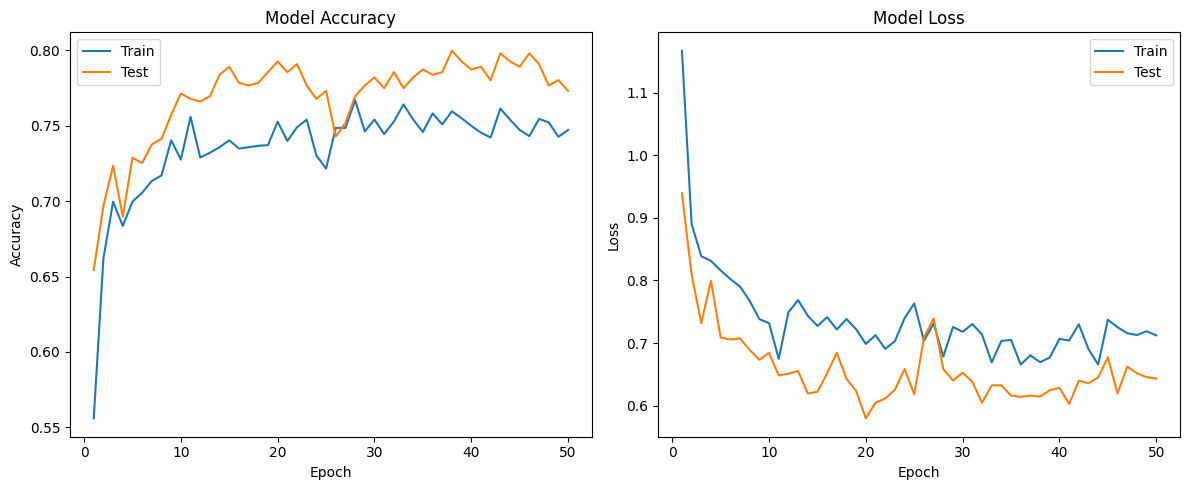

In [37]:
# Train the model
history_transfer_learning, all_preds, all_labels = train_model(model, train_loader, test_loader, criterion, optimizer_transfer, device)

# Plot training history
plot_training_history(history_transfer_learning)

# Plot confusion matrix
plot_confusion_matrix(all_preds, all_labels, class_names, 'Transfer Learning')

### 11.2 Fine Tuning

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.6481, Train Acc: 0.5231, Test Loss: 1.5751, Test Acc: 0.6028


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 1.5248, Train Acc: 0.6465, Test Loss: 1.5338, Test Acc: 0.6330


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 1.4650, Train Acc: 0.7083, Test Loss: 1.4597, Test Acc: 0.7181


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 1.4226, Train Acc: 0.7467, Test Loss: 1.4329, Test Acc: 0.7323


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 1.3976, Train Acc: 0.7764, Test Loss: 1.4185, Test Acc: 0.7642


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 1.3812, Train Acc: 0.7874, Test Loss: 1.4242, Test Acc: 0.7447


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 1.3632, Train Acc: 0.8107, Test Loss: 1.4221, Test Acc: 0.7500


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 1.3376, Train Acc: 0.8354, Test Loss: 1.4066, Test Acc: 0.7642


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 1.3368, Train Acc: 0.8395, Test Loss: 1.3912, Test Acc: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 1.3265, Train Acc: 0.8477, Test Loss: 1.3990, Test Acc: 0.7819


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 1.3273, Train Acc: 0.8427, Test Loss: 1.3846, Test Acc: 0.8014


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 1.3193, Train Acc: 0.8532, Test Loss: 1.4105, Test Acc: 0.7553


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 1.3069, Train Acc: 0.8610, Test Loss: 1.3937, Test Acc: 0.7784


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 1.3132, Train Acc: 0.8564, Test Loss: 1.3860, Test Acc: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 1.3076, Train Acc: 0.8596, Test Loss: 1.3958, Test Acc: 0.7713


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 1.3025, Train Acc: 0.8701, Test Loss: 1.3790, Test Acc: 0.7890


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 1.3121, Train Acc: 0.8573, Test Loss: 1.3726, Test Acc: 0.7943


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 1.2942, Train Acc: 0.8779, Test Loss: 1.3746, Test Acc: 0.7890


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 1.2951, Train Acc: 0.8779, Test Loss: 1.3771, Test Acc: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 1.2952, Train Acc: 0.8743, Test Loss: 1.3631, Test Acc: 0.8050


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 1.2852, Train Acc: 0.8820, Test Loss: 1.3609, Test Acc: 0.8067


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 1.2814, Train Acc: 0.8875, Test Loss: 1.3582, Test Acc: 0.8050


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 1.2734, Train Acc: 0.8989, Test Loss: 1.3518, Test Acc: 0.8138


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 1.2806, Train Acc: 0.8880, Test Loss: 1.3492, Test Acc: 0.8262


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 1.2812, Train Acc: 0.8866, Test Loss: 1.3607, Test Acc: 0.8156


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 1.2780, Train Acc: 0.8903, Test Loss: 1.3505, Test Acc: 0.8227


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 1.2688, Train Acc: 0.8985, Test Loss: 1.3496, Test Acc: 0.8156


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 1.2725, Train Acc: 0.8976, Test Loss: 1.3445, Test Acc: 0.8191


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 1.2726, Train Acc: 0.8948, Test Loss: 1.3504, Test Acc: 0.8156


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 1.2657, Train Acc: 0.9049, Test Loss: 1.3522, Test Acc: 0.8121


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 1.2645, Train Acc: 0.9058, Test Loss: 1.3431, Test Acc: 0.8245


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 1.2632, Train Acc: 0.9076, Test Loss: 1.3445, Test Acc: 0.8191


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 1.2717, Train Acc: 0.8939, Test Loss: 1.3535, Test Acc: 0.8121


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 1.2619, Train Acc: 0.9063, Test Loss: 1.3505, Test Acc: 0.8174


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 1.2540, Train Acc: 0.9168, Test Loss: 1.3565, Test Acc: 0.8014


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 1.2538, Train Acc: 0.9172, Test Loss: 1.3503, Test Acc: 0.8138


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 1.2542, Train Acc: 0.9150, Test Loss: 1.3367, Test Acc: 0.8369


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 1.2503, Train Acc: 0.9204, Test Loss: 1.3419, Test Acc: 0.8245


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 1.2542, Train Acc: 0.9154, Test Loss: 1.3420, Test Acc: 0.8245


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 1.2555, Train Acc: 0.9131, Test Loss: 1.3363, Test Acc: 0.8298


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 1.2501, Train Acc: 0.9191, Test Loss: 1.3413, Test Acc: 0.8262


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 1.2465, Train Acc: 0.9232, Test Loss: 1.3395, Test Acc: 0.8245


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 1.2613, Train Acc: 0.9113, Test Loss: 1.3430, Test Acc: 0.8245


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 1.2475, Train Acc: 0.9191, Test Loss: 1.3358, Test Acc: 0.8262


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 1.2490, Train Acc: 0.9177, Test Loss: 1.3519, Test Acc: 0.8085


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 1.2443, Train Acc: 0.9223, Test Loss: 1.3375, Test Acc: 0.8316


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 1.2515, Train Acc: 0.9182, Test Loss: 1.3461, Test Acc: 0.8174


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 1.2496, Train Acc: 0.9177, Test Loss: 1.3465, Test Acc: 0.8138


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 1.2425, Train Acc: 0.9250, Test Loss: 1.3472, Test Acc: 0.8138


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 1.2435, Train Acc: 0.9236, Test Loss: 1.3425, Test Acc: 0.8209


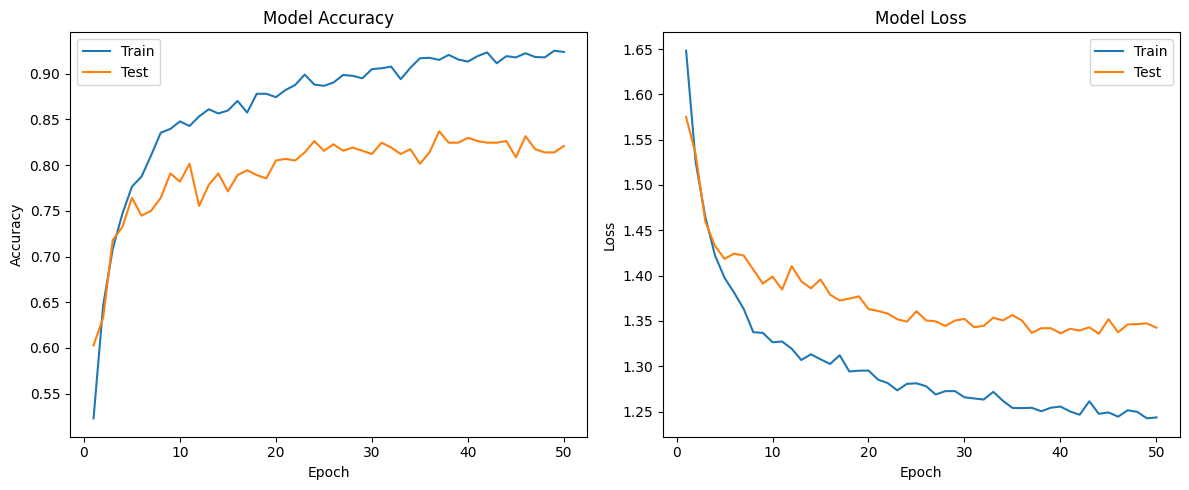

In [38]:
# Train the model
history_fine_tuning, all_preds_fine, all_labels_fine = train_model(model_Res, train_loader, test_loader, criterion, optimizer_fine, device)

# Plot training history
plot_training_history(history_fine_tuning)

# Plot confusion matrix
plot_confusion_matrix(all_preds_fine, all_labels_fine, class_names, 'Fine Tuning')